In [11]:
from itertools import combinations
import random
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import re
import matplotlib.colors as mcolors
import time
from datetime import timedelta
import math
import os
import datetime

In [12]:
def erdos_renyi_signed_graph(num_nodes, avg_degree):
    # Generate a random graph using Erdős-Rényi model
    G = nx.erdos_renyi_graph(num_nodes, avg_degree / (num_nodes - 1))
    
    # Assign random signs to the edges
    for u, v in G.edges():
        sign = random.choice([1, -1])
        G[u][v]["sign"] = sign
    
    return G

def generate_weakly_complete_signed_graph(n, p):
    # Generate a complete graph
    G = nx.complete_graph(n)
    
    # Randomly assign signs to the edges
    for u, v in G.edges():
        sign = random.choice([1, -1])  # Randomly choose +1 or -1 as the sign
        G[u][v]['sign'] = sign
    
    return G

def read_signed_graph_from_file(file_path):
    
    # read the give file and convert it as graph
    
    graph = {}
    with open(file_path, 'r') as file:
        for line in file:
            source, target, weight = map(int, line.strip().split())
            if source not in graph:
                graph[source] = []
            if target not in graph:
                graph[target] = []
            graph[source].append((target, weight))
            graph[target].append((source, weight))
    return graph

def convert_graph_to_dict(G):
    # making graph_dict for further purpose
    graph_dict = {}
    for u, v, sign in G.edges(data="sign"):
        if u not in graph_dict:
            graph_dict[u] = []
        if v not in graph_dict:
            graph_dict[v] = []
        graph_dict[u].append((v, sign))
        graph_dict[v].append((u, sign))
    
    return graph_dict
    

def visualize_signed_graph(G):

    # Visualize the graph with positive edges in green and negative edges in red
    
    pos = nx.spring_layout(G)
    positive_edges = [(u, v) for u, v, sign in G.edges(data="sign") if sign == 1]
    negative_edges = [(u, v) for u, v, sign in G.edges(data="sign") if sign == -1]

    plt.figure(figsize=(6,4))

    nx.draw_networkx_nodes(G, pos, nodelist = list(G.nodes()), node_color="white", node_size=500, edgecolors='black', linewidths=1.0)
    nx.draw_networkx_edges(G, pos, edgelist=positive_edges, edge_color='green')
    nx.draw_networkx_edges(G, pos, edgelist=negative_edges, edge_color='red')
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')
    
    plt.plot([0], color='green', label='Positive Connection')
    plt.plot([0], color='red', label='Negative Connection')

    # Adding legend
    plt.legend(loc='lower right')

    plt.title("Original Graph")
    plt.tight_layout()


    plt.show()
    

def write_signed_graph_to_file(graph):
    current_date = datetime.datetime.now().strftime("%Y-%m-%d-%m-%s")
    filepath = fr"{os.getcwd()}/generated_files/"
    filename = filepath + f"signed_graph_{current_date}.txt"
    
    with open(filename, 'w') as file:
        for u, v, data in graph.edges(data=True):
            sign = data.get('sign', 1)
            file.write(f"{u} {v} {sign}\n")


In [13]:
def find_pos_and_neg(graph):
    all_pos_node = []
    pos = dict()
    neg = dict()
    
    for node in graph:
        pos[node] = []
        neg[node] = []
        for nei, sign in graph[node]:
            if sign == 1:
                pos[node].append(nei)
            else:
                neg[node].append(nei)
        
        for node in pos[node]:
            if node not in all_pos_node:
                all_pos_node.append(node)
    return all_pos_node, pos ,neg
        

def generate_cluster(all_pos_node, pos):
    clu = list(list())
    index = 0
    is_checks = True
    
    while is_checks:
        start_node = random.choice(all_pos_node)
        clu.append(pos[start_node])
        
        for value in clu[index]:
            if value in all_pos_node: 
                all_pos_node.remove(value) 
        
        for nodes in clu[index]:
            for value in pos[nodes]:
                if value not in clu[index]:
                    clu[index].append(value)
                    if value in all_pos_node: 
                        all_pos_node.remove(value)
                  
        if not all_pos_node:
            is_checks = False  
        index += 1     
    return clu, all_pos_node
    
def check_balanced(clu, neg):
    for cluster_set in clu:
        for nodes in cluster_set:
            for neg_nei in neg[nodes]:
                for checking_node in cluster_set:
                    if neg_nei == checking_node:
                        return 0
    
    if len(clu) <= 2:
        return 1
    else:
        return 2
    
def is_complete(graph):
    num_nodes = len(graph.nodes)
    return all(len(graph.edges(node)) == num_nodes - 1 for node in graph.nodes)

def preparing_graph_to_visualize(file_path):
    Grp = nx.Graph()
    graph_list = list()
    with open(file_path, 'r') as file:
        for line in file:
            source, target, weight = map(int, line.strip().split())
            val = (source, target, {'sign':weight})
            graph_list.append(val)
            
    Grp.add_edges_from(graph_list)
    return Grp


def check_smallest_defensive_alliance(G, graph_dict):
    
    if not is_complete(G):
        print("Given graph is not a complete graph.")
    else:
        n = len(list(G.nodes()))
        all_pos_node, pos, neg = find_pos_and_neg(graph_dict)
        clu , all_pos_node = generate_cluster(all_pos_node, pos)
        is_balanced = check_balanced(clu, neg)
    
        if is_balanced == 0:
            print("Given graph is not K balanced graph.")
        else:
            
            sorted_clu = sorted(clu, key=len, reverse=True)
    
            clu1 = sorted_clu[0] if len(clu) > 0 else [] 
            clu2 = sorted_clu[1] if len(clu) > 1 else []
    
            if len(clu1) >= (n/2):
        
                asd = n - len(clu1)
                min_def_alliance = list(combinations(clu1, asd))
                
                print("Size of the smallest defensive allaince of the graph", asd)
                print("The defensive alliance of given graph are", min_def_alliance)
        
            elif len(clu1) >= n/3 and len(clu2) >= n/3:
                asd = 2 * (math.ceil((n - len(clu2)) / 2))
        
                c1_combinations = list(combinations(clu1, int(asd/2)))
                c2_combinations = list(combinations(clu2, int(asd/2)))
                
                min_def_alliance = []
                
                for val in c1_combinations:
                    for val2 in c2_combinations: 
                        comb_values = val + val2
                        min_def_alliance.append(comb_values)
                    
                print("Size of the smallest defensive allaince of the graph is", asd)
                print("The defensive alliance of given graph are", min_def_alliance)
            
            else:
                 print("No defensive alliance exists")
    
    

Size of the smallest defensive allaince of the graph is 10
The defensive alliance of given graph are [(1, 2, 3, 4, 5, 7, 8, 9, 10, 6)]
Total time taken: 0:00:00.002832


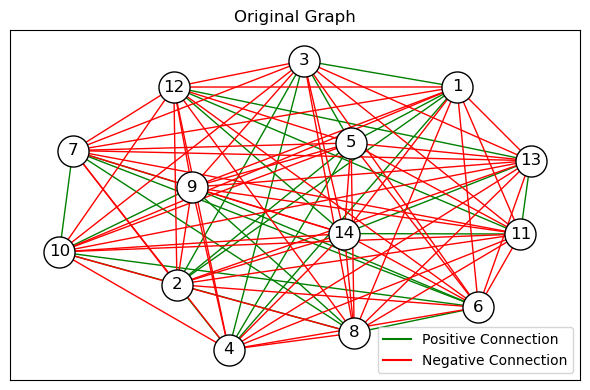

In [16]:
# start time recorded
start_time = time.monotonic()
#### Finding smallest defensive alliance in weakly signed complete graph ######


#### ------- ###### : (This is to generate random graph and caluculating ASD)
# num_nodes = 100
# avg_degree = 4
# G = erdos_renyi_signed_graph(num_nodes, avg_degree) 

# # Generate a random complete signed graph using Erdős-Rényi model
# # Parameters
# # num_nodes = 5  # Number of nodes
# # edge_probability = 0.2  # Probability of edge existence between nodes
# # G = generate_weakly_complete_signed_graph(num_nodes, edge_probability)


# graph_dict = convert_graph_to_dict(G)
# check_smallest_defensive_alliance(G,graph_dict)
# visualize_signed_graph(G) 
# write_signed_graph_to_file(G)


#### ------- ###### : (This is for reading file, creating graph and caluculating ASD)
file_path = fr"{os.getcwd()}/graph_test_files/test3.txt"
# read graph and convert it into dictionary 
graph_dict = read_signed_graph_from_file(file_path) 
G = preparing_graph_to_visualize(file_path)   

check_smallest_defensive_alliance(G,graph_dict)
# end time recorded
end_time = time.monotonic()
print("Total time taken:",timedelta(seconds=end_time - start_time))

visualize_signed_graph(G) 